## 1.5. Analysis of ISG expression

This notebook uses a list of previously identified interferon stimulated genes (ISGs) to analyze the global response of the dataset to the IFN-alpha stimulus. The list of ISGs (`interferon_stimulated_genes.csv`) has been compiled by the Essers lab and can be found on the GitHub page in the `data/gene_lists` folder.

In [1]:
### loading python libraries

# standard libraries
import numpy as np
import pandas as pd

# single cell libraries
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 0 

# plotting libraries
from matplotlib import pyplot as plt
plt.rcParams['pdf.fonttype'] = 42 #for saving PDF with changeable text
plt.rcParams['ps.fonttype'] = 42 #for saving PDF with changeable text

# other 
import warnings
warnings.filterwarnings('ignore') #ignore filter warnings
import sklearn as sk #used for L2 normalization
import sklearn.preprocessing #used for L2 normalization
import scipy.stats as stats #for statistical test

# import own functions
from plotting import *

### Load data

Here, we load the filtered HSPC dataset (as filtered in notebook 1.3) and the ISG gene list.

In [2]:
### load Anndata object with the HSPC dataset (all four subsets incl.)
adata_path = "../data/count_matrices/all_filtered.h5ad"
adata = sc.read_h5ad(adata_path)

In [3]:
### L2 normalize dataset
adata.X = sk.preprocessing.normalize(adata.X, norm='l2')

In [4]:
### scale dataset
sc.pp.scale(adata)

In [5]:
### load ISG list (400+ genes)
isg_path = "../data/gene_lists/interferon_stimulated_genes.csv"
isgs = pd.read_csv(isg_path, sep=";")
isgs = isgs["Gene"].values #move genes from dataframe to array

### Score cells for ISG expression
Here, we use the Scanpy built-in tool "score_genes" to score each gene for the average expression of the set of ISGs. For more information see: https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.score_genes.html

In [6]:
### score all cells for ISG expression
sc.tl.score_genes(adata, isgs, score_name="ISG_score")

In [7]:
### get minimum and maximum found ISG score
max_value = adata.obs["ISG_score"].max()
min_value = adata.obs["ISG_score"].min()

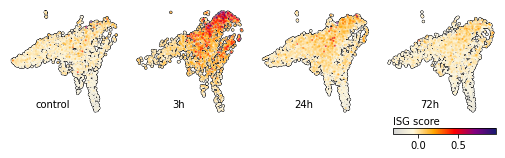

In [8]:
plot_UMAP_per_timepoint(
    adata, 
    "ISG_score", 
    min_value=min_value, 
    max_value=max_value,
    var_label="ISG score", 
    save=True, 
    time_key="time",
    save_path="../figures/1.5.ISG_score_UMAP_per_timepoint.pdf"
)

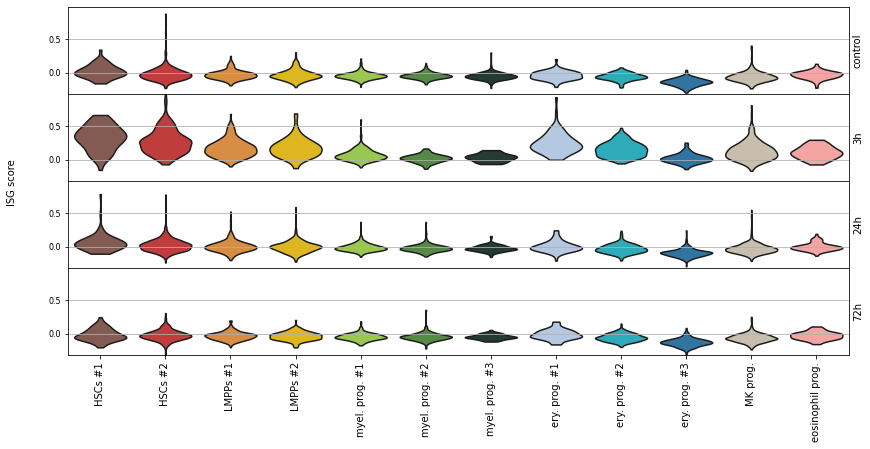

In [9]:
### plot ISG score per cluster for each cluster (violinplot)
times = adata.obs["time"].cat.categories

fig, axs = plt.subplots(len(times), 1, figsize=(14,1.6*len(times)), gridspec_kw={'wspace':0.1, 'hspace':0})

for i in range(len(times)):
    sc.pl.violin(adata[adata.obs["time"] == times[i]], "ISG_score", groupby="clusters", ax=axs[int(i)], jitter=0.4, show=False, ylabel=times[i], rotation=90, stripplot=False)

for ax in axs.flat:
    ax.get_xaxis().set_visible(False)
    ax.tick_params(axis='y', which='major', labelsize=8)
    ax.tick_params(axis='y', which='minor', labelsize=8)
    ax.set_ylim(min_value, max_value)
    ax.yaxis.set_label_position("right")
    ax.grid(axis='y')

fig.text(0.065, 0.5, 'ISG score', va='center', rotation='vertical')    
    
axs[len(times)-1].get_xaxis().set_visible(True)

# save figure
save_path = "../figures/1.5.ISG_score_violinplot_timepoints_clusters.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)

plt.show()

### Applying statistical test to data

Here, we apply the Wilcoxon rank-sum test to test whether the ISG score in the treatment timepoints is statistically different from the control timepoint.

In [18]:
# extract relevant data from AnnData object
timepoints = adata.obs["time"]
clusters = adata.obs["clusters"]
scores = adata.obs["ISG_score"]

# create a DataFrame to store the results
results = pd.DataFrame(columns=["cluster", "timepoint", "U-statistic", "p-value", "p-value_formatted"])

# perform Mann-Whitney U test for each cluster and timepoint
for cluster in adata.obs["clusters"].cat.categories.values:
    control_scores = scores[(timepoints == "control") & (clusters == cluster)]
    
    for timepoint in timepoints.unique():
        if timepoint != "control":
            treatment_scores = scores[(timepoints == timepoint) & (clusters == cluster)]
            
            U_statistic, p_value = stats.mannwhitneyu(control_scores, treatment_scores, alternative="less")
            
            # Format p-value with decimal precision
            p_value_formatted = "{:.4f}".format(p_value)
            
            results = results.append(
                {"cluster": cluster, "timepoint": timepoint, "U-statistic": U_statistic, "p-value": p_value, "p-value_formatted": p_value_formatted},
                ignore_index=True
            )

# print the results
print(results)

             cluster timepoint  U-statistic       p-value p-value_formatted
0            HSCs #1        3h        213.0  4.989581e-14            0.0000
1            HSCs #1       24h       1751.0  5.189801e-02            0.0519
2            HSCs #1       72h       2053.0  9.838535e-01            0.9839
3            HSCs #2        3h       5811.0  3.092320e-86            0.0000
4            HSCs #2       24h      56577.0  1.115236e-12            0.0000
5            HSCs #2       72h      66256.0  4.023246e-01            0.4023
6           LMPPs #1        3h       2066.0  3.981473e-49            0.0000
7           LMPPs #1       24h      24218.0  3.458142e-07            0.0000
8           LMPPs #1       72h      24037.0  6.543362e-01            0.6543
9           LMPPs #2        3h       1613.0  3.262225e-32            0.0000
10          LMPPs #2       24h      20787.0  6.354290e-06            0.0000
11          LMPPs #2       72h      15537.0  4.516177e-01            0.4516
12    myel. 